In [1]:
# fundamentals
import os, glob
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
# import funcs as funcs
import datetime
import imp

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=12)
plt.rc('facecolor', )

# met mast functions and utilities
import sys
sys.path.append('../')
import met_funcs as MET
import vis as vis
import utils as utils

In [6]:
# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/)
towerID = 'M5'
metPathLoHz = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/{}/txt/'.format(towerID)
# figPath = '../../figs/{}'.format(towerID)
datapath = '../example_data/'.format(towerID)

figPath = '../figs_20181108'

In [7]:
# time range
years  = [ int(a) for a in np.arange(2012,2018,1) ] #
months = [ int(a) for a in np.arange(1,12.1,1) ]
# or just get all?

In [8]:
inputfiles = [] # list of files to be read into metdata object
filecount = 0

for year in years:
    for month in months:
        fName = glob.glob(os.path.join(metPathLoHz,'{0}_{1}.txt'.format(year,month_name[month])))        
        if len(fName)>0:
            fName = fName[0] 
            inputfiles.append(fName)
print('{} files to be read into MetData'.format(len(inputfiles)))


64 files to be read into MetData


In [9]:
fPaths = os.listdir(datapath)

for ifile, file in enumerate(fPaths):
    loadfile = os.path.join(datapath,file)
    
    temp = pd.read_csv(loadfile)
    
    if ifile==0:
        metdat = temp
    else:
        metdat = metdat.append(temp)

# Reindex with date
metdat.set_index('Date', inplace=True)
metdat.index = pd.to_datetime(metdat.index)
metdat.index = metdat.index.tz_localize('UTC').tz_convert('America/Denver')    
catinfo = MET.get_catinfo(metdat)

In [10]:
# ## load data from list of input data files
# metdat = MET.load_met_data(inputfiles, verbose=False)

# ## remove columns that are all nans
# MET.drop_nan_cols(metdat)

# ## use qc columns to mask data (qc != 1 --> questionable data)
# metdat = MET.qc_mask(metdat)

# ## flag data by stability class
# stabconds, stabcat = MET.flag_stability(metdat)

# ## group columns based on category, assign units, labels, savenames
# varcats, varunits, varlabels, varsave = MET.categorize_fields(metdat, keeplist=True)

# ## drop columns not in any of the categories, filter TI, temperature, stability parameters
# MET.groom_data(metdat, varcats)

# filtcols = [col for col in metdat.columns if 'air' not in col.lower() and 'humidity' not in col.lower()]
# ## Finally, reject outliers more than 5 standard deviations from the mean
# for col in metdat.columns:
#     try:
#         metdat[col] = MET.reject_outliers(metdat[col], m=6)
#     except:
#         continue

In [8]:
# catinfo = {}
# catinfo['columns'] = varcats
# catinfo['units'] = varunits
# catinfo['labels'] = varlabels
# catinfo['save'] = varsave

In [9]:
# M5 excluded angles,
# Obstruction,	start ang.	end ang.
# GE			46		146
# Alstom		123		203
# CART-3		172		213
# CART-2		177		212
# Siemens		165		210
# Gamesa		189		228
exclude_angles = [(46,146),(123,203),(172,213),(177,212),(165,210),(189,228)]

In [12]:
tempcol,_,_ = utils.get_vertical_locations(catinfo['columns']['air temperature'])
temperaturedata = metdat[tempcol]
presscol,_,_ = utils.get_vertical_locations(catinfo['columns']['air pressure'])
pressuredata = metdat[presscol]

In [13]:
tempcol[::2]

['Air Temperature (3 m)',
 'Air Temperature (38 m)',
 'Air temperature (sonic_61m)',
 'Air Temperature (87 m)',
 'Air temperature (sonic_119m)']

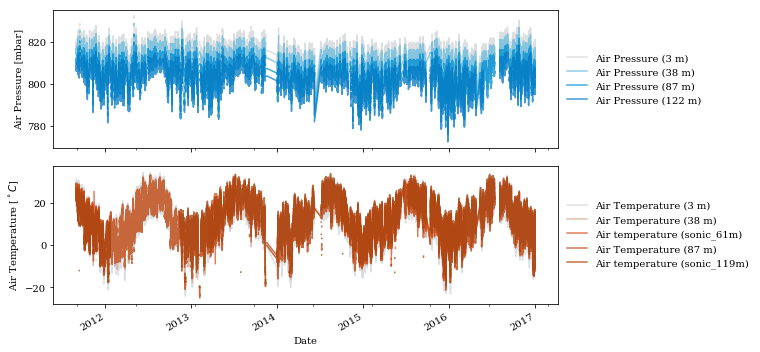

In [14]:
fig, ax = plt.subplots(2,1, figsize = (8,5), sharex=True)

colors = utils.get_colors(len(presscol), basecolor='blue')
pressuredata.plot.line(ax=ax.flatten()[0], color=colors, legend=False, alpha=0.75)
leg = ax.flatten()[0].legend(presscol, frameon=False, loc=6, bbox_to_anchor=(1,0.5))
ax.flatten()[0].set_ylabel(catinfo['labels']['air pressure'])

colors = utils.get_colors(len(tempcol[::2]), basecolor='red')
temperaturedata[tempcol[::2]].plot.line(ax=ax.flatten()[1], color=colors, legend=False, alpha=0.75)
leg = ax.flatten()[1].legend(tempcol[::2], frameon=False, loc=6, bbox_to_anchor=(1,0.5))
ax.flatten()[1].set_ylabel(catinfo['labels']['air temperature'])

fig.tight_layout()
# fig.savefig(os.path.join(figPath,'M5_pressure_v_temperature_timeseries.png'), dpi=200, bbox_inches='tight')

# Cut by TI

In [15]:
turbclasses = np.linspace(0,50,6)
turbcol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns']['ti'], 87)

metdat['turbclass'] = pd.cut(metdat[turbcol], turbclasses, include_lowest=False).astype(str)
metdat['turbclass'].value_counts()

temp = metdat.groupby('turbclass')
turbclasses = list(temp.groups.keys())[:-1]
lowTI = temp.get_group(turbclasses[0])

In [25]:
plotcats = ['air density',
            'air pressure',
            'air temperature',
            'direction',
            'relative humidity',
            'speed',
            'wind shear',
            'wind veer']
lowtifigpath = figPath
# lowtifigpath = '../../figs/lowTI'
try:
    os.makedirs(lowtifigpath)
except:
    pass

# Full data histograms

In [17]:
catinfo['labels']['direction']

'Wind Direction [$^\\circ$]'

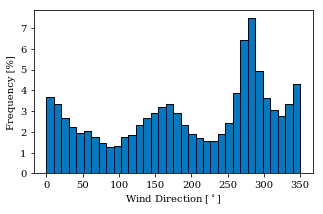

In [18]:
nrelcolors = utils.get_nrelcolors()

for cat in ['direction']:#plotcats:
    
    height = 87
    if 'shear' in cat.lower():
        height = 110

    plotvar, probe_height, _ = utils.get_vertical_locations(catinfo['columns'][cat], height)

    fulldat = metdat[plotvar].dropna().sort_values()
    fulldat = MET.reject_outliers(fulldat,m=4)

    fig, ax = plt.subplots(figsize=(5,3))
    
    binwidth = np.round((fulldat.max()-fulldat.min())/35.0,decimals=3)
    bins = np.arange(fulldat.min(), fulldat.max(), binwidth)
    
    fulldat.plot.hist(bins = bins, 
                        color=nrelcolors['blue'][0],
                        edgecolor='k',
                        alpha=1,
                        ax=ax,
                        weights=np.ones(len(fulldat))/len(fulldat)*100,
                        legend=False)

    ax.set_xlabel(catinfo['labels'][cat])
    ax.set_ylabel('Frequency [%]')

#     fig.savefig(os.path.join(figPath,'M5_{}_hist_comp_{}m.png'.format(catinfo['save'][cat],probe_height)),dpi=200,bbox_inches='tight')
    
#     plt.clf()
    

# Low TI histograms comparisons

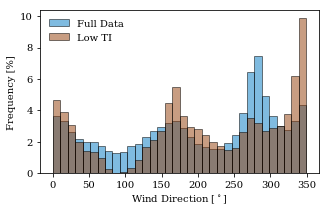

In [19]:
nrelcolors = utils.get_nrelcolors()

for cat in ['direction']:#plotcats:
    
    height = 87
    if 'shear' in cat.lower():
        height = 110

    plotvar, _, _ = utils.get_vertical_locations(catinfo['columns'][cat], height)

    fulldat = metdat[plotvar].dropna().sort_values()
    fulldat = MET.reject_outliers(fulldat,m=4)
    lowtidat = lowTI[plotvar].dropna().sort_values()
    lowtidat = MET.reject_outliers(lowtidat,m=4)
    
    result = pd.concat([fulldat, lowtidat], axis=1)
    fig, ax = plt.subplots(figsize=(5,3))
    
    binwidth = np.round((fulldat.max()-fulldat.min())/35.0,decimals=3)
    bins = np.arange(fulldat.min(), fulldat.max(), binwidth)
    
    fulldat.plot.hist(bins = bins, 
                        color=nrelcolors['blue'][0],
                        edgecolor='k',
                        alpha=0.5,
                        ax=ax,
                        weights=np.ones(len(fulldat))/len(fulldat)*100,
                        legend=False)

    lowtidat.plot.hist(bins = bins, 
                        color=nrelcolors['red'][0],
                        edgecolor='k',
                        alpha=0.5,
                        ax=ax,
                        weights=np.ones(len(lowtidat))/len(lowtidat)*100, 
                        legend=False)

    ax.set_xlabel(catinfo['labels'][cat])
    ax.set_ylabel('Frequency [%]')
    leg = ax.legend(['Full Data', 'Low TI'], frameon=False)

#     fig.savefig(os.path.join(lowtifigpath,'LOWTI_{}_hist_comp.png'.format(catinfo['save'][cat])),dpi=200,bbox_inches='tight')
    
#     plt.clf()
    

In [268]:
turbcol,_,_ = utils.get_vertical_locations(catinfo['columns']['ti'], 87)
nrelcolors= utils.get_nrelcolors()
colors = utils.get_colors(5, basecolor='span')


In [21]:
# test = metdat.groupby([metdat.index.weekofyear,'turbclass'])
test = metdat.groupby([metdat.index.dayofyear,'turbclass'])
test2 = test[turbcol].count().unstack().drop('nan',axis=1).transpose()
test2 = test2/test2.sum()
test2 = test2.transpose()
test2.mean()*100
test2.std()*100

turbclass
(0.0, 10.0]     7.186107
(10.0, 20.0]    6.015319
(20.0, 30.0]    4.138803
(30.0, 40.0]    2.598775
(40.0, 50.0]    1.477940
dtype: float64

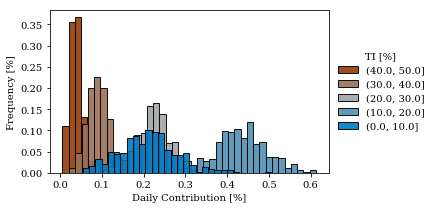

In [43]:
test3 = test2[test2.columns[-1::-1]]
colors = utils.get_colors(5, basecolor='span',reverse=True)

fig, ax = plt.subplots(figsize=(5,3))

for ii,turb in enumerate(turbclasses[-1::-1]):
    data = test3[turb].dropna()
    plt.hist(data, bins=np.arange(data.min(),data.max(),0.015), 
                    color=colors[ii],
                    edgecolor='k',
                    alpha=0.9,
                    weights= np.ones(len(data))/len(data), density=False)
ax.set_xlabel('Daily Contribution [%]')
ax.set_ylabel('Frequency [%]')
leg = ax.legend(turbclasses[-1::-1], loc=6, bbox_to_anchor = (1,0.5), frameon=False)
leg.set_title(catinfo['labels']['ti'])
fig.savefig(os.path.join(lowtifigpath,'TI_frequency_hist.png'),dpi=200,bbox_inches='tight')

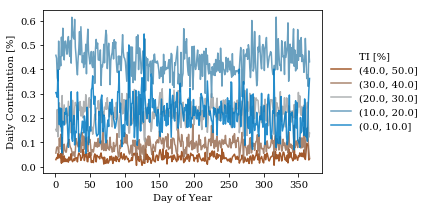

In [44]:
test3 = test2[test2.columns[-1::-1]]
colors = utils.get_colors(5, basecolor='span',reverse=True)

fig, ax = plt.subplots(figsize=(5,3))

for ii,turb in enumerate(turbclasses[-1::-1]):
    data = test3[turb]
    ax.plot(data, color=colors[ii],alpha=0.85,)
#                     edgecolor='k',
#                     alpha=0.85,
#                     weights= 100*np.ones(len(data))/len(data), density=False)
#     data.plot.kde(color=colors[ii], ax=ax)
# ax.set_xlim(0,0.65)
ax.set_xlabel('Day of Year')
ax.set_ylabel('Daily Contribution [%]')
leg = ax.legend(turbclasses[-1::-1], loc=6, bbox_to_anchor = (1,0.5), frameon=False)
leg.set_title(catinfo['labels']['ti'])
fig.savefig(os.path.join(lowtifigpath,'LOWTI_timeseries.png'),dpi=200,bbox_inches='tight')

In [34]:
test3 = test2[test2.columns[-1::-1]]
times = pd.to_datetime(test3.index, format='%j')
pd.DatetimeIndex(times)#, format='%m-%d')

DatetimeIndex(['1900-01-01', '1900-01-02', '1900-01-03', '1900-01-04',
               '1900-01-05', '1900-01-06', '1900-01-07', '1900-01-08',
               '1900-01-09', '1900-01-10',
               ...
               '1900-12-23', '1900-12-24', '1900-12-25', '1900-12-26',
               '1900-12-27', '1900-12-28', '1900-12-29', '1900-12-30',
               '1900-12-31', '1901-01-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)

In [35]:
import matplotlib.dates as mdates

test3 = test2[test2.columns[-1::-1]]
times = pd.to_datetime(test3.index, format='%j')
test3 = test3.set_index(times.format('%m'))

fig, ax = plt.subplots(figsize=(5,3))
ax = test3.plot(x=test3.index, color=colors, ax=ax)
leg = ax.legend(turbclasses[-1::-1], loc=6, bbox_to_anchor=(1,0.5), frameon=False)
leg.set_title(catinfo['labels']['ti'])
ax.set_ylabel('Daily Contribution [%]')
ax.set_xlabel('Day of Year')
ax.format_xdata = mdates.DateFormatter('%m')
# fig.savefig(os.path.join(lowtifigpath,'LOWTI_plot_by_day.png'),dpi=200,bbox_inches='tight')

KeyError: 'Date'

## Low TI figs


In [29]:
categories = list(catinfo['columns'].keys())

for cat in ['speed']:#categories:
    if 'stability flag' in cat.lower():
        continue
    
#     # savepath for new figs
#     savecat = catinfo['save'][cat]
#     catfigpath = os.makedirs(os.path.join(figPath,savecat), mode=0o777, exist_ok=True)
#     catfigpath = os.path.join(figPath,savecat)
    
    # Profiles
    ## cumulative profile
    fig, ax = vis.cumulative_profile(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_profile.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly profile
    fig, ax = vis.monthly_profile(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## stability profile
    fig,ax = vis.stability_profile(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_profile_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly stability profile
    fig,ax = vis.monthly_stability_profiles(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_profile_monthly_stability.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    # Diurnal cycle
    ## cumulative hourly plot
    fig,ax = vis.hourlyplot(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_hourly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')
    
    ## monthly hourly plot
    fig,ax = vis.monthlyhourlyplot(lowTI, catinfo, cat)
#     fig.savefig(os.path.join(catfigpath,'{}_{}_hourly_monthly.png'.format(towerID, savecat)), dpi=200, bbox_inches='tight')

    plt.close('all')
    
    

In [142]:
temp = lowTI.copy()
temp = temp.groupby(temp.index.month)

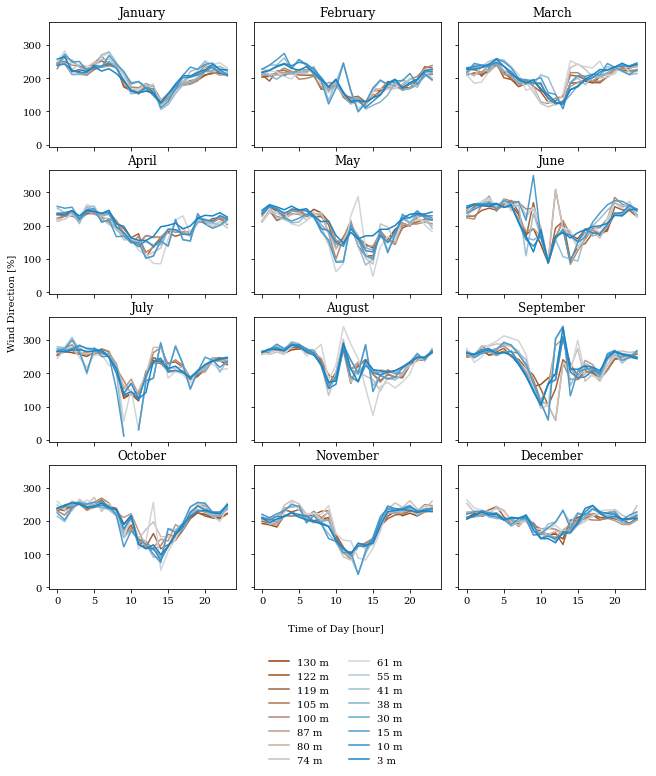

In [153]:
fig,ax = vis.monthlyhourlyplot(lowTI,catinfo,'direction')
fig.savefig(os.path.join(lowtifigpath,'TI_hourly_monthly.png'),dpi=200,bbox_inches='tight')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


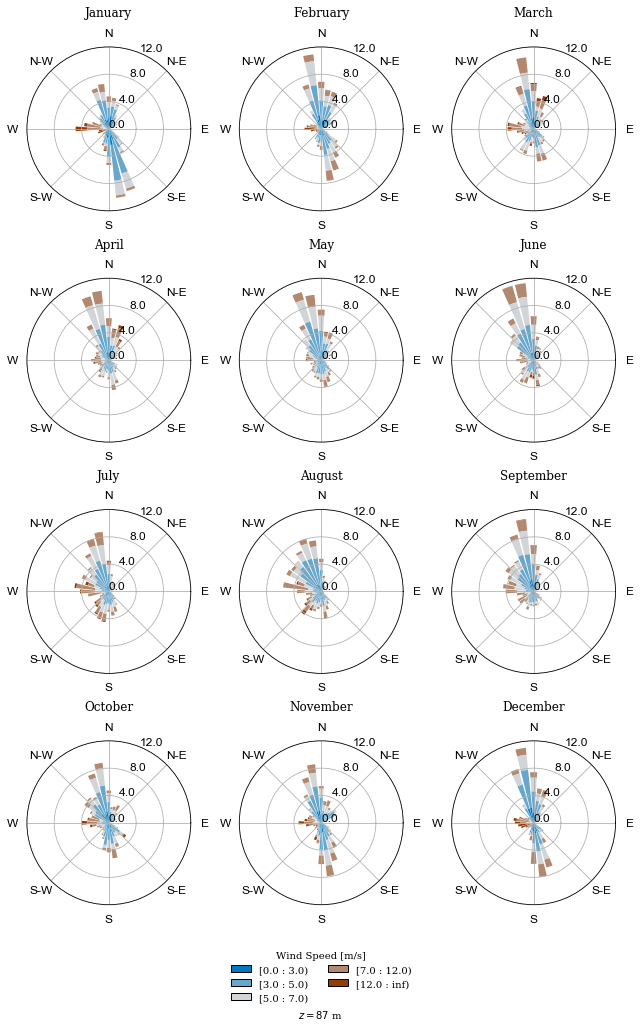

In [152]:
fig, ax, leg = vis.monthly_rose_fig(lowTI,catinfo,'speed',vertloc=90, bins=[0,3,5,7,12], ylim=12)
fig.savefig(os.path.join(lowtifigpath,'TI_monthly_wind_rose.png'),dpi=200,bbox_inches='tight')

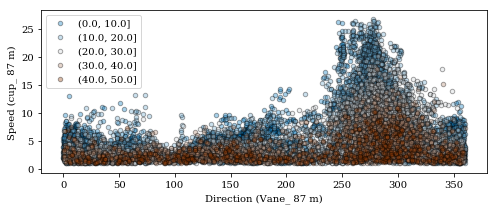

In [54]:
dircol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns']['direction'], 87)
spdcol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns']['speed'], 87)
colors = utils.get_colors(5,basecolor='span')

fig,ax = plt.subplots(figsize=(8,3))
for ii, tclass in enumerate(turbclasses):
    test.get_group((1,tclass)).plot.scatter(dircol, spdcol, color=colors[ii], alpha = 0.35, edgecolor='k', ax=ax)
ax.legend(turbclasses)

Text(0.5,1,'Monin-Obukhov Length [m]')

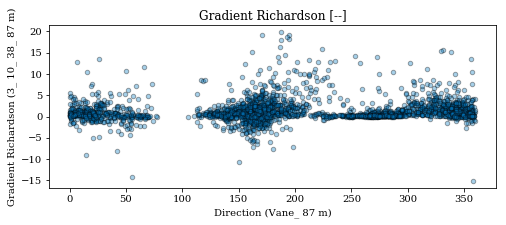

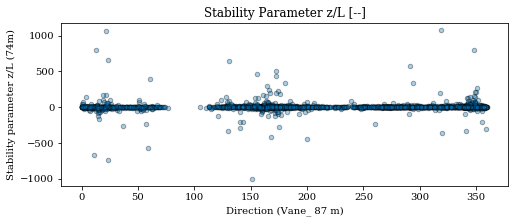

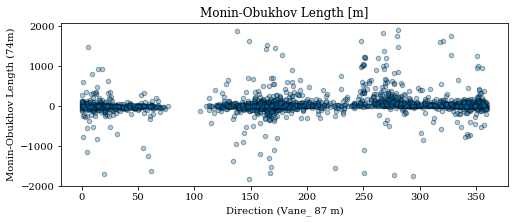

In [65]:
dircol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns']['direction'], 87)

fig, ax = plt.subplots(figsize=(8,3))
cat = 'gradient richardson'
stabcol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns'][cat], 87)
test.get_group((1,turbclasses[0])).plot.scatter(dircol, stabcol, color=colors[0], alpha = 0.35, edgecolor='k', ax=ax)
ax.set_title(catinfo['labels'][cat])

fig, ax = plt.subplots(figsize=(8,3))
cat = 'stability parameter z/l'
stabcol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns'][cat], 87)
test.get_group((1,turbclasses[0])).plot.scatter(dircol, stabcol, color=colors[0], alpha = 0.35, edgecolor='k', ax=ax)
ax.set_title(catinfo['labels'][cat])

fig, ax = plt.subplots(figsize=(8,3))
cat = 'monin-obukhov length'
stabcol, probe_heights, _ = utils.get_vertical_locations(catinfo['columns'][cat], 87)
test.get_group((1,turbclasses[0])).plot.scatter(dircol, stabcol, color=colors[0], alpha = 0.35, edgecolor='k', ax=ax)
ax.set_title(catinfo['labels'][cat])

# Weibull distribution

In [93]:
import windrose
import scipy.stats as stats

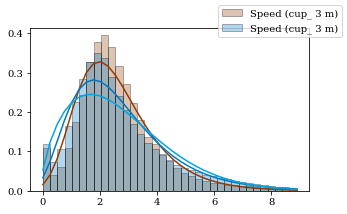

In [166]:
speedcols, _, _ = utils.get_vertical_locations(catinfo['columns']['speed'])

for plotvar in speedcols[0:1]:
    fulldat = metdat[plotvar].dropna()
    fulldat = MET.reject_outliers(fulldat,m=4)
    lowtidat = lowTI[plotvar].dropna()
    lowtidat = MET.reject_outliers(lowtidat,m=4)

    binwidth = np.round((lowtidat.max()-lowtidat.min())/35.0,decimals=3)
    bins = np.arange(lowtidat.min(), lowtidat.max(), binwidth)

    nrecolors = utils.get_nrelcolors()

    binwidth = np.round((lowtidat.max()-lowtidat.min())/35.0,decimals=3)
    bins = np.arange(lowtidat.min(), lowtidat.max(), binwidth)

    fig, ax = plt.subplots(figsize = (5,3))
    
    lowtiparams = stats.exponweib.fit(lowtidat, fc=1)
    ax.plot(bins, stats.exponweib.pdf(bins, *lowtiparams), color=nrecolors['red'][0])

    # thing,stuff = 
    output = ax.hist(lowtidat, 
                bins = bins, 
                facecolor=nrecolors['red'][0], 
                edgecolor='k',
                alpha=0.3,
                normed=True)

    fullparams = stats.exponweib.fit(fulldat, fc=1)
    pdf = stats.exponweib.pdf(bins, *fullparams)
    ax.plot(bins, pdf, color=nrecolors['blue'][0])

    fullparams = stats.weibull_min.fit(fulldat)
    pdf = stats.weibull_min.pdf(bins, *fullparams)
    ax.plot(bins, pdf)

    # thing,stuff = 
    output = ax.hist(fulldat, 
                bins = bins, 
                facecolor=nrecolors['blue'][0], 
                edgecolor='k',
                alpha=0.3,
                normed=True)
    
    leg = fig.legend()
#     fig.savefig(os.path.join(lowtifigpath,'TI_monthly_wind_rose.png'),dpi=200,bbox_inches='tight')

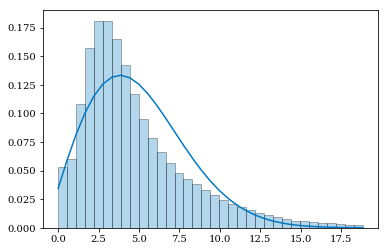

In [157]:
plotvar, _, _ = utils.get_vertical_locations(catinfo['columns']['speed'], height)
fulldat = metdat[plotvar].dropna().sort_values()
fulldat = MET.reject_outliers(fulldat,m=4)

binwidth = np.round((fulldat.max()-fulldat.min())/35.0,decimals=3)
bins = np.arange(fulldat.min(), fulldat.max(), binwidth)

fullparams = stats.rayleigh.fit(fulldat)

plt.plot(bins, stats.rayleigh.pdf(bins, *fullparams), color=nrecolors['blue'][0])

output = plt.hist(fulldat, 
            bins = bins, 
            facecolor=nrecolors['blue'][0], 
            edgecolor='k',
            alpha=0.3,
            normed=True)

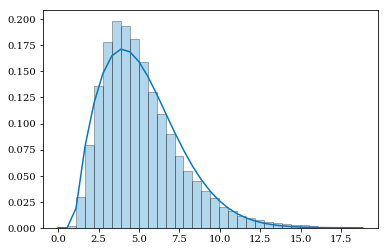

In [154]:
fullparams = stats.weibull_min.fit(lowtidat, floc=1)
pdf = stats.weibull_min.pdf(bins, *fullparams)
plt.plot(bins, pdf, color=nrecolors['blue'][0])

# thing,stuff = 
output = plt.hist(lowtidat, 
            bins = bins, 
            facecolor=nrecolors['blue'][0], 
            edgecolor='k',
            alpha=0.3,
            normed=True)

In [155]:
fullparams

(1.7976211520736225, 1, 4.690619269983553)